# Unsupervised Clustering of Vine Labels

### What am i doing in this notebook?


* by encoding the images through a trained convolutional network, and then apply a clustering algorithm to the encoded features.

### import the libraries

Keras is using a TensorFlow backend in our case here.

In [1]:
% matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

Using TensorFlow backend.


## Dataset information

* Code - serves when the dataset divided in subfolders


In [2]:
# directory where images are stored
DIR = "./images"

def dataset_stats():
    

    vine_labels = ['C', 'D']
    
    # dictionary where we will store the stats
    stats = []
    
    for animal in vine_labels:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, animal)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df

In [3]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
C,C-labels,617


### Loading the images

Now we create a function that loads all images in a directory for a given array of codes in one array and creates the corresponding label array for them.

Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by VGG19 which we will be using later.

In [4]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(file)

    return images, labels

In [5]:
codes = ["C"]
images, labels = load_images(codes)

### Normalise...

Now convert the images and labels to NumPy arrays to make processing them easier. Then normaise the images before passing them on to VGG19

In [6]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [7]:
images, labels = normalise_images(images, labels)

### Time to mix it up!

Photos and their labels in arrays. Shuffle them around, and split them to three different sets... training, validation and testing.

We'll be using the `train_test_split` function from sklearn which will also shuffle the data around, since it's currently in order.

In [8]:
def shuffle_data(images, labels):

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0, random_state=728)
    
    return X_train, y_train

In [9]:
X_train, y_train = shuffle_data(images, labels)

In [10]:
X_train.shape

(617, 224, 224, 3)

### Load pre-trained covnet models
#### VGG16, VG19, ResNet50

Load up the keras models with the imagenet weights without top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [11]:
# Load the models with ImageNet weights

vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))




### Output of ConvNets and Flattening

The covnet models will give us 3D vectors that represent the image. We need to flatten these for the clustering algorithms to start working with them.

In [12]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat


In [13]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features
ResNet50 flattened output has 100352 features


The above cell shows us the number of features each covnet gives to a single image. When we compare these to the original size of the image 224 x 224 x 3 = 150,528 pixels/features, we can see that this is a large reduction in what the clustering algorithms will have to work with.

 

These reduces number of feature should represent more meaningful features in the image structure.

### PCA

While k-means clustering has coped with these numbers, Gaussian Mixture Modelling has not and the computer consistently ran out of memory and struggled to produce results. 

We therefore look to PCA for dimensionality reduction, so that our clustering algorithms can cope.

In [14]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [15]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)


In [16]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

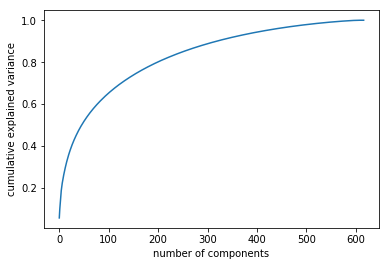

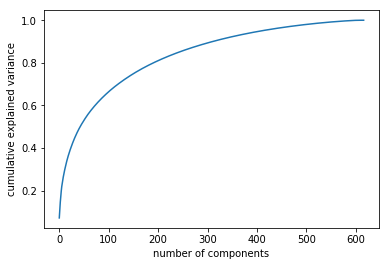

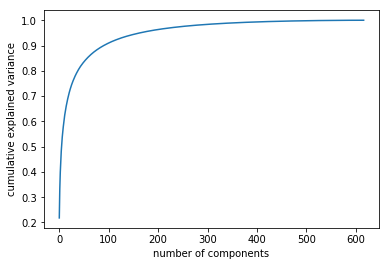

In [17]:
# Plot the cumulative explained variance for each convnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

Looking at the gaphs above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.

It is also interesting to note the difference in shape between the VGG graphs and the ResNet one. This is probably due to the fact that ResNet only had 2048 dimensions, while VGGs had 25,088

In [18]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

### Clustering

Let's write a couple of functions that would create and fit KMeans and Gaussian Mixture models.
While it can make sense to combine them in one function that returns both, I've seperated them so we can execute them seperately and make some observations without overloading the PC

In [19]:
def create_train_kmeans(data, number_of_clusters=8):#len(codes)
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728, n_init=20)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [20]:
def create_train_gmm(data, number_of_clusters=8):#len(codes)
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g
    

### Training clustering models


In [21]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 1.0445325374603271 seconds

VGG19
Training took 0.9289391040802002 seconds

ResNet50
Training took 0.7218403816223145 seconds


In [22]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

print("\nResNet50")
G_resnet50_pca = create_train_gmm(resnet50_output_pca)


GMM (PCA): 

VGG16
Training took 0.25474071502685547 seconds

VGG19
Training took 0.24722027778625488 seconds

ResNet50
Training took 0.2426166534423828 seconds


In [23]:
# models for the convnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)


KMeans: 

VGG16:
Training took 18.848307132720947 seconds

VGG19:
Training took 18.936999797821045 seconds

ResNet50:
Training took 30.442610025405884 seconds


In [24]:
# get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

In [25]:
# Associate images with corresponding buckets by "what netwark sees as similarity"

In [26]:
# d = {'image': labels, 'cluster': k_vgg16_pred_pca}
df = pd.DataFrame(data= {'image': labels, 'cluster': k_vgg16_pred_pca})
df = df[['image','cluster']]

In [27]:
df.head()

,image,cluster
0,351.png,7
1,170.png,7
2,540.png,7
3,504.png,2
4,176.png,3


In [28]:
# Now we get the custer model predictions

# KMeans with PCA outputs
df_k_vgg16_pred_pca = pd.DataFrame(data= {'image': labels, 'cluster': k_vgg16_pred_pca})
df_k_vgg16_pred_pca = df_k_vgg16_pred_pca[['image','cluster']]
df_k_vgg16_pred_pca.to_csv('df_k_vgg16_pred_pca.csv')

df_k_vgg19_pred_pca = pd.DataFrame(data= {'image': labels, 'cluster': k_vgg19_pred_pca})
df_k_vgg19_pred_pca = df_k_vgg19_pred_pca[['image','cluster']]
df_k_vgg19_pred_pca.to_csv('df_k_vgg19_pred_pca.csv')

df_k_resnet50_pred_pca = pd.DataFrame(data= {'image': labels, 'cluster': k_resnet50_pred_pca})
df_k_resnet50_pred_pca = df_k_resnet50_pred_pca[['image','cluster']]
df_k_resnet50_pred_pca.to_csv('df_k_resnet50_pred_pca.csv')

# KMeans with CovNet outputs
df_k_vgg16_pred = pd.DataFrame(data= {'image': labels, 'cluster': k_vgg16_pred})
df_k_vgg16_pred = df_k_vgg16_pred[['image','cluster']]
df_k_vgg16_pred.to_csv('df_k_vgg16_pred.csv')

df_k_vgg19_pred = pd.DataFrame(data= {'image': labels, 'cluster': k_vgg19_pred})
df_k_vgg19_pred = df_k_vgg19_pred[['image','cluster']]
df_k_vgg19_pred.to_csv('df_k_vgg19_pred.csv')

df_k_resnet50_pred = pd.DataFrame(data= {'image': labels, 'cluster': k_resnet50_pred})
df_k_resnet50_pred = df_k_resnet50_pred[['image','cluster']]
df_k_resnet50_pred.to_csv('df_k_resnet50_pred.csv')

# Gaussian Mixture with PCA outputs
df_g_resnet50_pred_pca = pd.DataFrame(data= {'image': labels, 'cluster': g_resnet50_pred_pca})
df_g_resnet50_pred_pca = df_g_resnet50_pred_pca[['image','cluster']]
df_g_resnet50_pred_pca.to_csv('df_g_resnet50_pred_pca.csv')

df_g_vgg16_pred_pca = pd.DataFrame(data= {'image': labels, 'cluster': g_vgg16_pred_pca})
df_g_vgg16_pred_pca = df_g_vgg16_pred_pca[['image','cluster']]
df_g_vgg16_pred_pca.to_csv('df_g_vgg16_pred_pca.csv')

df_g_vgg19_pred_pca = pd.DataFrame(data= {'image': labels, 'cluster': g_vgg19_pred_pca})
df_g_vgg19_pred_pca = df_g_vgg19_pred_pca[['image','cluster']]
df_g_vgg19_pred_pca.to_csv('df_g_vgg19_pred_pca.csv')

# preview example results

In [29]:
df_g_vgg19_pred_pca.head(6)

,image,cluster
0,351.png,7
1,170.png,6
2,540.png,7
3,504.png,1
4,176.png,0
5,411.png,4


Remember that the clustering algorith does not detect which images are merlots and chardones, it only groups images that look alike together and assigns them a to a bucket arbitrarily. 

In [30]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [31]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, y_train)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca, y_train)
g_resnet50_cluster_count_pca = cluster_label_count(g_resnet50_pred_pca, y_train)

In [32]:
print("KMeans VGG16: ")
vgg16_cluster_count.head(4)

KMeans VGG16: 


,0,1,2,3,4,5,6,7
10.png,0,0,0,0,0,0,0,1
100.png,0,1,0,0,0,0,0,0
101.png,0,0,0,0,0,0,0,1
102.png,0,1,0,0,0,0,0,0


In [33]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca.head(4)

KMeans VGG16 (PCA): 


,0,1,2,3,4,5,6,7
10.png,0,0,0,0,0,0,0,1
100.png,0,1,0,0,0,0,0,0
101.png,0,0,0,0,0,0,0,1
102.png,0,1,0,0,0,0,0,0


In [34]:
print("GMM VGG16: ")
g_vgg16_cluster_count_pca.head(4)

GMM VGG16: 


,0,1,2,3,4,5,6,7
10.png,0,1,0,0,0,0,0,0
100.png,0,0,0,0,0,0,0,1
101.png,0,1,0,0,0,0,0,0
102.png,0,0,0,0,0,0,0,1


We can see now that the Gaussian Model did not give a meaningful result. There are no clear dominant code for each cluster

In [35]:
print("KMeans VGG19: ")
vgg19_cluster_count.head(4)

KMeans VGG19: 


,0,1,2,3,4,5,6,7
10.png,0,0,1,0,0,0,0,0
100.png,1,0,0,0,0,0,0,0
101.png,0,0,1,0,0,0,0,0
102.png,1,0,0,0,0,0,0,0


In [36]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca.head(4)

KMeans VGG19 (PCA): 


,0,1,2,3,4,5,6,7
10.png,0,0,1,0,0,0,0,0
100.png,1,0,0,0,0,0,0,0
101.png,0,0,1,0,0,0,0,0
102.png,1,0,0,0,0,0,0,0


In [37]:
print("GMM VGG19 (PCA): ")
g_vgg19_cluster_count_pca.head(4)

GMM VGG19 (PCA): 


,0,1,2,3,4,5,6,7
10.png,0,0,0,0,0,0,0,1
100.png,1,0,0,0,0,0,0,0
101.png,0,0,0,0,0,0,0,1
102.png,1,0,0,0,0,0,0,0


In [38]:
print("KMeans Resnet50: ")
resnet_cluster_count.head(4)

KMeans Resnet50: 


,0,1,2,3,4,5,6,7
10.png,0,0,0,0,0,1,0,0
100.png,0,0,0,0,0,0,0,1
101.png,0,1,0,0,0,0,0,0
102.png,0,1,0,0,0,0,0,0


In [39]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca.head(4)

Kmeans Resnet50 (PCA): 


,0,1,2,3,4,5,6,7
10.png,0,0,0,0,0,1,0,0
100.png,0,0,0,0,0,0,0,1
101.png,0,1,0,0,0,0,0,0
102.png,0,1,0,0,0,0,0,0


In [40]:
print("GMM Resnet50 (PCA): ")
g_resnet50_cluster_count_pca.head(4)

GMM Resnet50 (PCA): 


,0,1,2,3,4,5,6,7
10.png,1,0,0,0,0,0,0,0
100.png,0,0,0,0,0,0,0,1
101.png,0,0,1,0,0,0,0,0
102.png,0,0,1,0,0,0,0,0


We can see again, that models which took ResNet50 representations could not produce meaningful clusters. We will therefore stop pursuing them.

The models that made it through are:

1. KMeans VGG16
2. KMeans VGG16 PCA
3. KMeans VGG19
4. KMeans VGG19 PCA


Let's calculate some scores and see which one performs best.